In [1]:
%cd /lustre/scratch126/cellgen/team205/aa34/Arian/Dis2P/dis2p_reproducibility

/lustre/scratch126/cellgen/team205/aa34/Arian/Dis2P/dis2p_reproducibility


/software/cellgen/team361/aa34/envs/disect/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
# enable autoreload
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import random

import scvi
scvi.settings.seed = 0
import scanpy as sc
import anndata as ad
import torch
import numpy as np
import pandas as pd
from datetime import datetime
from scipy.sparse import csr_matrix
torch.set_float32_matmul_precision('medium')
import warnings
warnings.simplefilter("ignore", UserWarning)
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import seaborn as sns

# from scfair.evaluate import *
# from scfair_reproducibility.evaluation.metrics import *

from celldisect import CellDISECT
import rapids_singlecell as rsc
# from dis2p_reproducibility.dis2p_defunct import dis2pvi as dvi

import scib

from sklearn.metrics import r2_score
from scipy.stats import pearsonr
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")

Global seed set to 0
Global seed set to 0


In [3]:
adata = sc.read_h5ad('../eraslan_preprocessed1212_split_deg.h5ad')
adata = adata[adata.layers['counts'].sum(1) != 0].copy()

In [4]:
adata.layers['counts'].max()

3370.0

In [5]:
adata.X.max()

9.210441

In [6]:
from typing import NamedTuple

class _REGISTRY_KEYS_NT(NamedTuple):
    X_KEY: str = "X"
    BATCH_KEY: str = "batch"
    LABELS_KEY: str = "labels"
    PROTEIN_EXP_KEY: str = "proteins"
    CAT_COVS_KEY: str = "extra_categorical_covs"
    CONT_COVS_KEY: str = "extra_continuous_covs"
    INDICES_KEY: str = "ind_x"
    SIZE_FACTOR_KEY: str = "size_factor"
    LATENT_MODE_KEY: str = "latent_mode"
    LATENT_QZM_KEY: str = "latent_qzm"
    LATENT_QZV_KEY: str = "latent_qzv"


REGISTRY_KEYS = _REGISTRY_KEYS_NT()

In [7]:
cats = ['tissue', 'Sample ID', 'sex', 'Age_bin']
split_key = 'split_2'
cell_type_included = False # Set to True if you have provided a cell type annotation in the cats list
if not cell_type_included:
    adata.obs["_cluster"] = (
        "0"  # Dummy obs for inference (not-training) time, to avoid computing neighbors and clusters again in setup_anndata | AVOID ADDING BEFORE TRAINING
    )
pre_path = '../models/ablation_celldisect_cfW/'
model_paths = []
for model_path in os.listdir(pre_path):
    model_paths.append(model_path)

In [8]:
model_paths = [p for p in model_paths if 'allones' in p]

In [9]:
model_paths

['celldisect_allones_cfW_0.8_split_split_2',
 'celldisect_allones_cfW_10.0_split_split_2',
 'celldisect_allones_cfW_2.0_split_split_2',
 'celldisect_allones_cfW_0.5_split_split_2',
 'celldisect_allones_cfW_0.0_split_split_2',
 'celldisect_allones_cfW_0.1_split_split_2',
 'celldisect_allones_cfW_1.0_split_split_2',
 'celldisect_allones_cfW_5.0_split_split_2']

In [10]:
names = [name.split('_')[-4] for name in model_paths]
names

['0.8', '10.0', '2.0', '0.5', '0.0', '0.1', '1.0', '5.0']

In [11]:
models = {}
for i, model_path in enumerate(model_paths):
    models[names[i]] = CellDISECT.load(f"{pre_path}/{model_path}", adata=adata)

INFO     File ../models/ablation_celldisect_cfW//celldisect_allones_cfW_0.8_split_split_2/model.pt already         
         downloaded                                                                                                


Cluster covariate already present in adata.obs, remove in case you want to re-run, skipping!
CUDA backend failed to initialize: Found CUDA version 12010, but JAX was built against version 12020, which is newer. The copy of CUDA that is installed must be at least as new as the version against which JAX was built. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


INFO     File ../models/ablation_celldisect_cfW//celldisect_allones_cfW_10.0_split_split_2/model.pt already        
         downloaded                                                                                                


Cluster covariate already present in adata.obs, remove in case you want to re-run, skipping!


INFO     File ../models/ablation_celldisect_cfW//celldisect_allones_cfW_2.0_split_split_2/model.pt already         
         downloaded                                                                                                


Cluster covariate already present in adata.obs, remove in case you want to re-run, skipping!


INFO     File ../models/ablation_celldisect_cfW//celldisect_allones_cfW_0.5_split_split_2/model.pt already         
         downloaded                                                                                                


Cluster covariate already present in adata.obs, remove in case you want to re-run, skipping!


INFO     File ../models/ablation_celldisect_cfW//celldisect_allones_cfW_0.0_split_split_2/model.pt already         
         downloaded                                                                                                


Cluster covariate already present in adata.obs, remove in case you want to re-run, skipping!


INFO     File ../models/ablation_celldisect_cfW//celldisect_allones_cfW_0.1_split_split_2/model.pt already         
         downloaded                                                                                                


Cluster covariate already present in adata.obs, remove in case you want to re-run, skipping!


INFO     File ../models/ablation_celldisect_cfW//celldisect_allones_cfW_1.0_split_split_2/model.pt already         
         downloaded                                                                                                


Cluster covariate already present in adata.obs, remove in case you want to re-run, skipping!


INFO     File ../models/ablation_celldisect_cfW//celldisect_allones_cfW_5.0_split_split_2/model.pt already         
         downloaded                                                                                                


Cluster covariate already present in adata.obs, remove in case you want to re-run, skipping!


In [12]:
models = dict(sorted(models.items(), key=lambda t: float(t[0])))

In [13]:
n_samples_from_source_max = 500

In [14]:
cell_type_to_check = 'Epithelial cell (luminal)'
n_samples_from_source = min(n_samples_from_source_max, len(adata[(adata.obs['Broad cell type'] == cell_type_to_check) &
                (adata.obs['tissue'] == 'breast') & (adata.obs['sex'] == 'female')]))


cov_names = ['sex', 'tissue']
cov_values = ['female', 'breast']
cov_values_cf = ['male', 'prostate gland']

adata_ = adata[adata.obs['Broad cell type'] == cell_type_to_check].copy()

In [15]:
RANDOM_SEED = 42
preds = {}
for name, model in models.items():
    x_ctrl, x_true, x_pred = model.predict_counterfactuals(
                                            adata_.copy(),
                                            cov_names=cov_names,
                                            cov_values=cov_values,
                                            cov_values_cf=cov_values_cf,
                                            cats=cats,
                                            n_samples_from_source=n_samples_from_source,
                                            seed=RANDOM_SEED,
                                            )

    x_ctrl, x_true, x_pred = np.log1p(x_ctrl), np.log1p(x_true), np.log1p(x_pred)
    preds[name] = x_pred

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer set

In [16]:
deg_list = adata.uns['rank_genes_groups_split_2']['male_prostate gland']
deg_list

array(['KLK4', 'AC005152.3', 'LINC01152', 'HP', 'CD177', 'KLK3',
       'PLA2G2A', 'XIST', 'KLK2', 'CPLX3', 'NKX3-1', 'RP11-395B7.2',
       'MSMB', 'ATOH8', 'ACPP', 'MT1G', 'S100P', 'ANKRD30A', 'NEFH',
       'IFI6', 'PCAT4', 'PGC', 'FTL', 'SLC45A3', 'CKB', 'GP2',
       'LINC01297', 'SLC38A11', 'MT1M', 'RPS4Y1', 'FGL1', 'RP1-288H2.2',
       'PLPP1', 'SORD', 'AKAP12', 'CYP1B1', 'SFN', 'ADIRF', 'CPNE4',
       'GPX3', 'UBA52', 'TIMP1', 'KIT', 'TMEFF2', 'TRPM8', 'ATP5E',
       'GABRP', 'HSPA1A', 'STAC2', 'UQCR10', 'MT2A', 'HERPUD1', 'S100A11',
       'SCD', 'RP11-33A14.1', 'SLC4A4', 'MT1E', 'PSCA', 'RP11-126O1.4',
       'UBB', 'VTCN1', 'IFITM3', 'AGR2', 'SCNN1G', 'TMSB10', 'NDUFA4',
       'SCHLAP1', 'AMD1', 'B2M', 'NDRG1', 'PSAP', 'KRT15', 'RP11-384F7.2',
       'STEAP2', 'CPE', 'COX7C', 'FAU', 'PRDX1', 'AQP3', 'ALOX15B',
       'GADD45G', 'SHROOM1', 'SERF2', 'LSAMP', 'DHCR24', 'UQCRB', 'ZNF90',
       'C19orf48', 'POLR2L', 'COX6B1', 'CST3', 'TXNRD1', 'ESR1', 'OOEP',
       'HGD', '

In [17]:
from scipy.stats import wasserstein_distance

emd_results = {}
for n_top_deg in [20, None]:
    if n_top_deg is not None:
        degs = np.where(np.isin(adata.var_names, deg_list[:n_top_deg]))[0]
    else:
        degs = np.arange(adata.n_vars)
        n_top_deg = 'all'
    emd_results[str(n_top_deg)] = {}
    for name, x_pred in preds.items():
        x_true_deg = x_true[:, degs]
        x_pred_deg = x_pred[:, degs]
        # for method_name, method in zip(['CellDISECT', 'Control'], [x_pred_deg, x_ctrl_deg]):
        wd = []
        for i in range(x_true_deg.shape[1]):
            wd.append(
                wasserstein_distance(torch.tensor(x_true_deg[:, i]), torch.tensor(x_pred_deg[:, i]))
            )
        emd_results[str(n_top_deg)][name] = np.mean(wd)

emd_results = pd.DataFrame.from_dict(emd_results).T
emd_results

,0.0,0.1,0.5,0.8,1.0,2.0,5.0,10.0
20,0.532806,0.530080,0.530420,0.531120,0.531810,0.533253,0.531474,0.531280
all,0.129833,0.119042,0.118707,0.119462,0.119205,0.119523,0.122298,0.122686


In [18]:
r2_results = {}
for n_top_deg in [20, None]:
    if n_top_deg is not None:
        degs = np.where(np.isin(adata.var_names, deg_list[:n_top_deg]))[0]
    else:
        degs = np.arange(adata.n_vars)
        n_top_deg = 'all'
    r2_results[str(n_top_deg)] = {}
    for name, x_pred in preds.items():
        
        x_true_deg = x_true[:, degs]
        x_pred_deg = x_pred[:, degs]

        r2_mean_deg = pearsonr(x_true_deg.mean(0), x_pred_deg.mean(0))

        r2_var_deg = pearsonr(x_true_deg.var(0), x_pred_deg.var(0))

        r2_results[str(n_top_deg)][name] = r2_mean_deg[0]

        r2_results[str(n_top_deg)][name+'_var'] = r2_var_deg[0]

r2_results = pd.DataFrame.from_dict(r2_results).T
r2_results

,0.0,0.0_var,0.1,0.1_var,0.5,0.5_var,0.8,0.8_var,1.0,1.0_var,2.0,2.0_var,5.0,5.0_var,10.0,10.0_var
20,-0.015110,-0.015589,0.160446,0.073296,0.129999,0.030826,0.08173,-0.020787,0.067683,-0.052786,-0.063177,-0.122078,0.023220,-0.055455,0.013985,-0.025615
all,0.317897,0.389703,0.510097,0.600543,0.504351,0.594094,0.47700,0.446249,0.462672,0.271643,0.416264,0.379905,0.072038,0.020403,0.028492,0.009434


In [19]:
r2_results_subtract = {}
for n_top_deg in [20, None]:
    if n_top_deg is not None:
        degs = np.where(np.isin(adata.var_names, deg_list[:n_top_deg]))[0]
    else:
        degs = np.arange(adata.n_vars)
        n_top_deg = 'all'
    r2_results_subtract[str(n_top_deg)] = {}
    for name, x_pred in preds.items():

        x_true_deg = x_true[:, degs]
        x_pred_deg = x_pred[:, degs]
        x_ctrl_deg = x_ctrl[:, degs]


        r2_mean_deg = pearsonr(x_true_deg.mean(0) - x_ctrl_deg.mean(0), x_pred_deg.mean(0) - x_ctrl_deg.mean(0))

        r2_var_deg = pearsonr(x_true_deg.var(0) - x_ctrl_deg.var(0), x_pred_deg.var(0) - x_ctrl_deg.var(0))

        r2_results_subtract[str(n_top_deg)][name] = r2_mean_deg[0]

        r2_results_subtract[str(n_top_deg)][name+'_var'] = r2_var_deg[0]

r2_results_subtract = pd.DataFrame.from_dict(r2_results_subtract).T
r2_results_subtract

,0.0,0.0_var,0.1,0.1_var,0.5,0.5_var,0.8,0.8_var,1.0,1.0_var,2.0,2.0_var,5.0,5.0_var,10.0,10.0_var
20,0.592621,0.625288,0.608809,0.625741,0.605056,0.625530,0.603006,0.625361,0.603754,0.625225,0.594108,0.624872,0.596214,0.625277,0.593601,0.625323
all,0.135927,0.034936,0.353764,0.072598,0.360706,0.079979,0.339496,0.073856,0.336005,0.072667,0.329898,0.086103,0.101164,0.032201,0.073436,0.029860


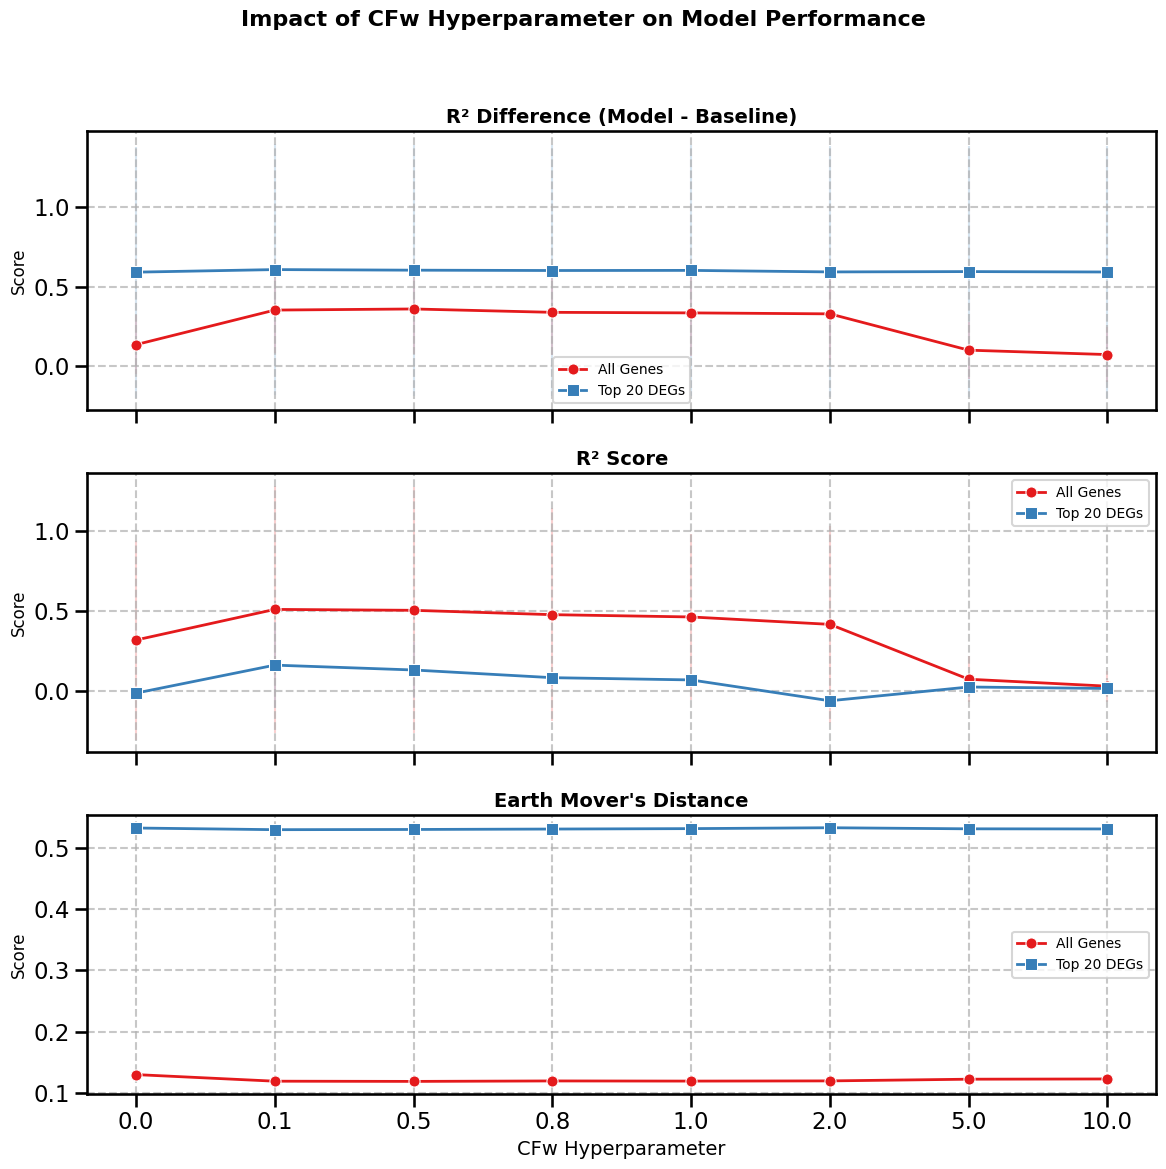

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Set up the figure with subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)
fig.subplots_adjust(hspace=0.3)

# Define hyperparameter values based on your screenshot
hyperparams = [0.0, 0.1, 0.5, 0.8, 1.0, 2.0, 5.0, 10.0]
hyperparams = [str(p) for p in hyperparams]

# Set up a consistent color palette
palette = sns.color_palette("Set1")

# Plot each metric in a separate subplot
for i, (df_name, title) in enumerate([
    ('r2_results_subtract', 'R² Difference (Model - Baseline)'),
    ('r2_results', 'R² Score'),
    ('emd_results', 'Earth Mover\'s Distance')
]):
    ax = axes[i]
    
    # Get the dataframe (assuming it's already in the environment)
    df = eval(df_name)
    
    # Plot 'all genes' as line
    sns.lineplot(x=hyperparams, y=df.loc['all', hyperparams], 
                 marker='o', linewidth=2, markersize=8, 
                 color=palette[0], label='All Genes', ax=ax)
    
    # Plot '20' (top DEGs) as line
    sns.lineplot(x=hyperparams, y=df.loc['20', hyperparams], 
                 marker='s', linewidth=2, markersize=8, 
                 color=palette[1], label='Top 20 DEGs', ax=ax)
    
    # Add error bands using the variance columns if needed
    for j, gene_set in enumerate(['all', '20']):
        for hp in hyperparams:
            if f"{hp}_var" in df.columns:
                y = df.loc[gene_set, hp]
                var = df.loc[gene_set, f"{hp}_var"]
                std_dev = np.sqrt(var)
                ax.fill_between([hp], [y-std_dev], [y+std_dev], 
                                color=palette[j], alpha=0.2)
    
    # Customize the subplot
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_ylabel('Score', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(fontsize=10)

# Set common x-axis label
axes[-1].set_xlabel('CFw Hyperparameter', fontsize=14)
axes[-1].set_xticks(hyperparams)

# Add a title for the entire figure
plt.suptitle('Impact of CFw Hyperparameter on Model Performance', fontsize=16, fontweight='bold', y=0.98)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show or save the figure
# plt.savefig('hyperparameter_ablation_results.png', dpi=300, bbox_inches='tight')
plt.show()

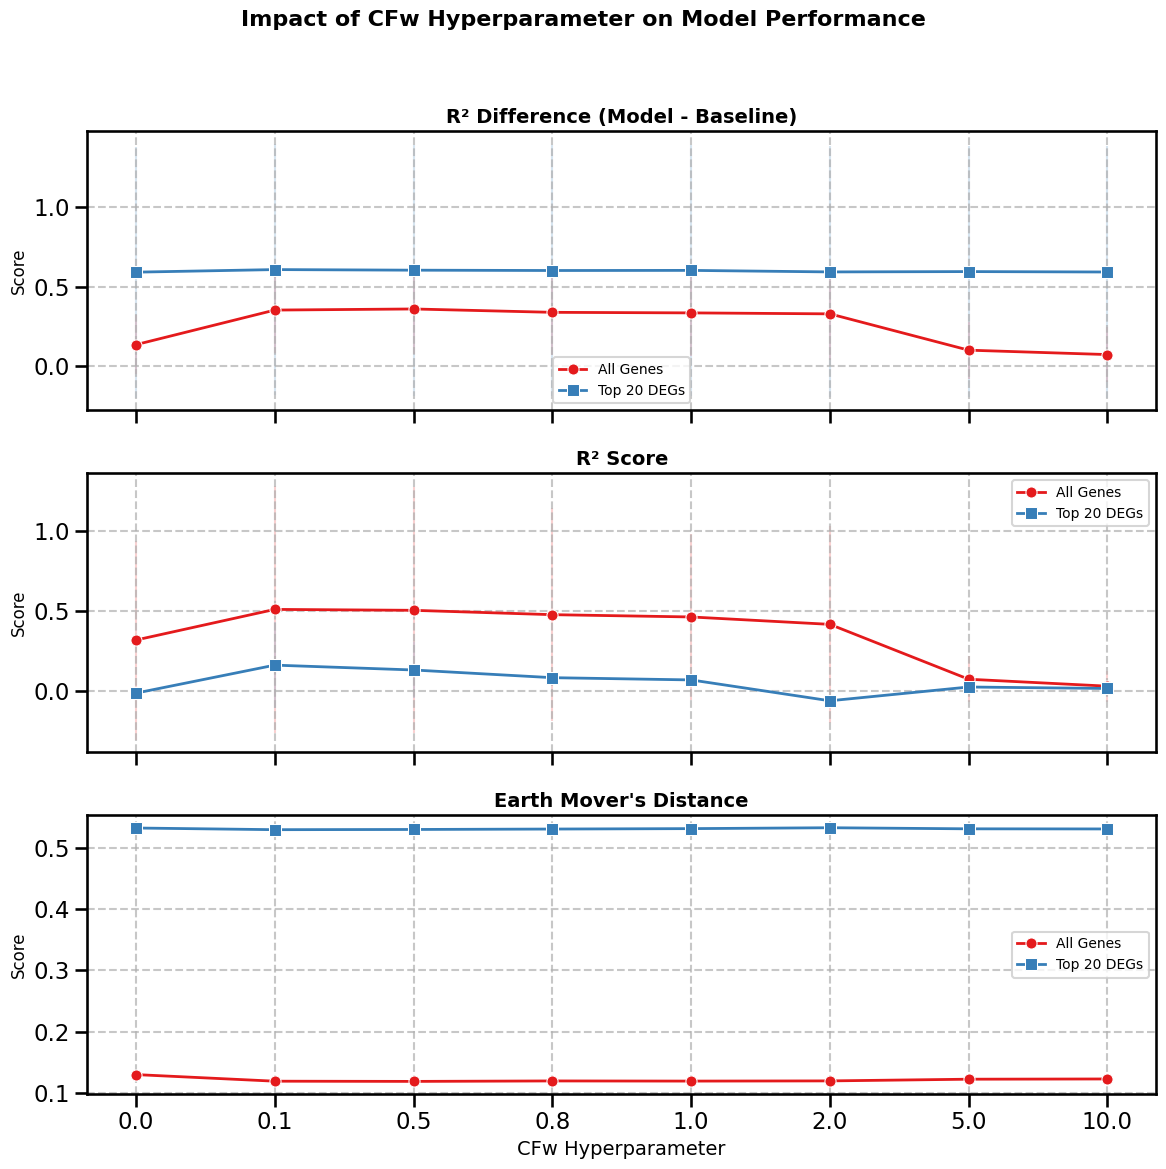

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Set up the figure with subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)
fig.subplots_adjust(hspace=0.3)

# Define hyperparameter values based on your screenshot
hyperparams = [0.0, 0.1, 0.5, 0.8, 1.0, 2.0, 5.0, 10.0]
hyperparams = [str(p) for p in hyperparams]

# Set up a consistent color palette
palette = sns.color_palette("Set1")

# Plot each metric in a separate subplot
for i, (df_name, title) in enumerate([
    ('r2_results_subtract', 'R² Difference (Model - Baseline)'),
    ('r2_results', 'R² Score'),
    ('emd_results', 'Earth Mover\'s Distance')
]):
    ax = axes[i]
    
    # Get the dataframe (assuming it's already in the environment)
    df = eval(df_name)
    
    # Plot 'all genes' as line
    sns.lineplot(x=hyperparams, y=df.loc['all', hyperparams], 
                 marker='o', linewidth=2, markersize=8, 
                 color=palette[0], label='All Genes', ax=ax)
    
    # Plot '20' (top DEGs) as line
    sns.lineplot(x=hyperparams, y=df.loc['20', hyperparams], 
                 marker='s', linewidth=2, markersize=8, 
                 color=palette[1], label='Top 20 DEGs', ax=ax)
    
    # Add error bands using the variance columns if needed
    for j, gene_set in enumerate(['all', '20']):
        for hp in hyperparams:
            if f"{hp}_var" in df.columns:
                y = df.loc[gene_set, hp]
                var = df.loc[gene_set, f"{hp}_var"]
                std_dev = np.sqrt(var)
                ax.fill_between([hp], [y-std_dev], [y+std_dev], 
                                color=palette[j], alpha=0.2)
    
    # Customize the subplot
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_ylabel('Score', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(fontsize=10)

# Set common x-axis label
axes[-1].set_xlabel('CFw Hyperparameter', fontsize=14)
axes[-1].set_xticks(hyperparams)

# Add a title for the entire figure
plt.suptitle('Impact of CFw Hyperparameter on Model Performance', fontsize=16, fontweight='bold', y=0.98)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show or save the figure
# plt.savefig('hyperparameter_ablation_results.png', dpi=300, bbox_inches='tight')
plt.show()

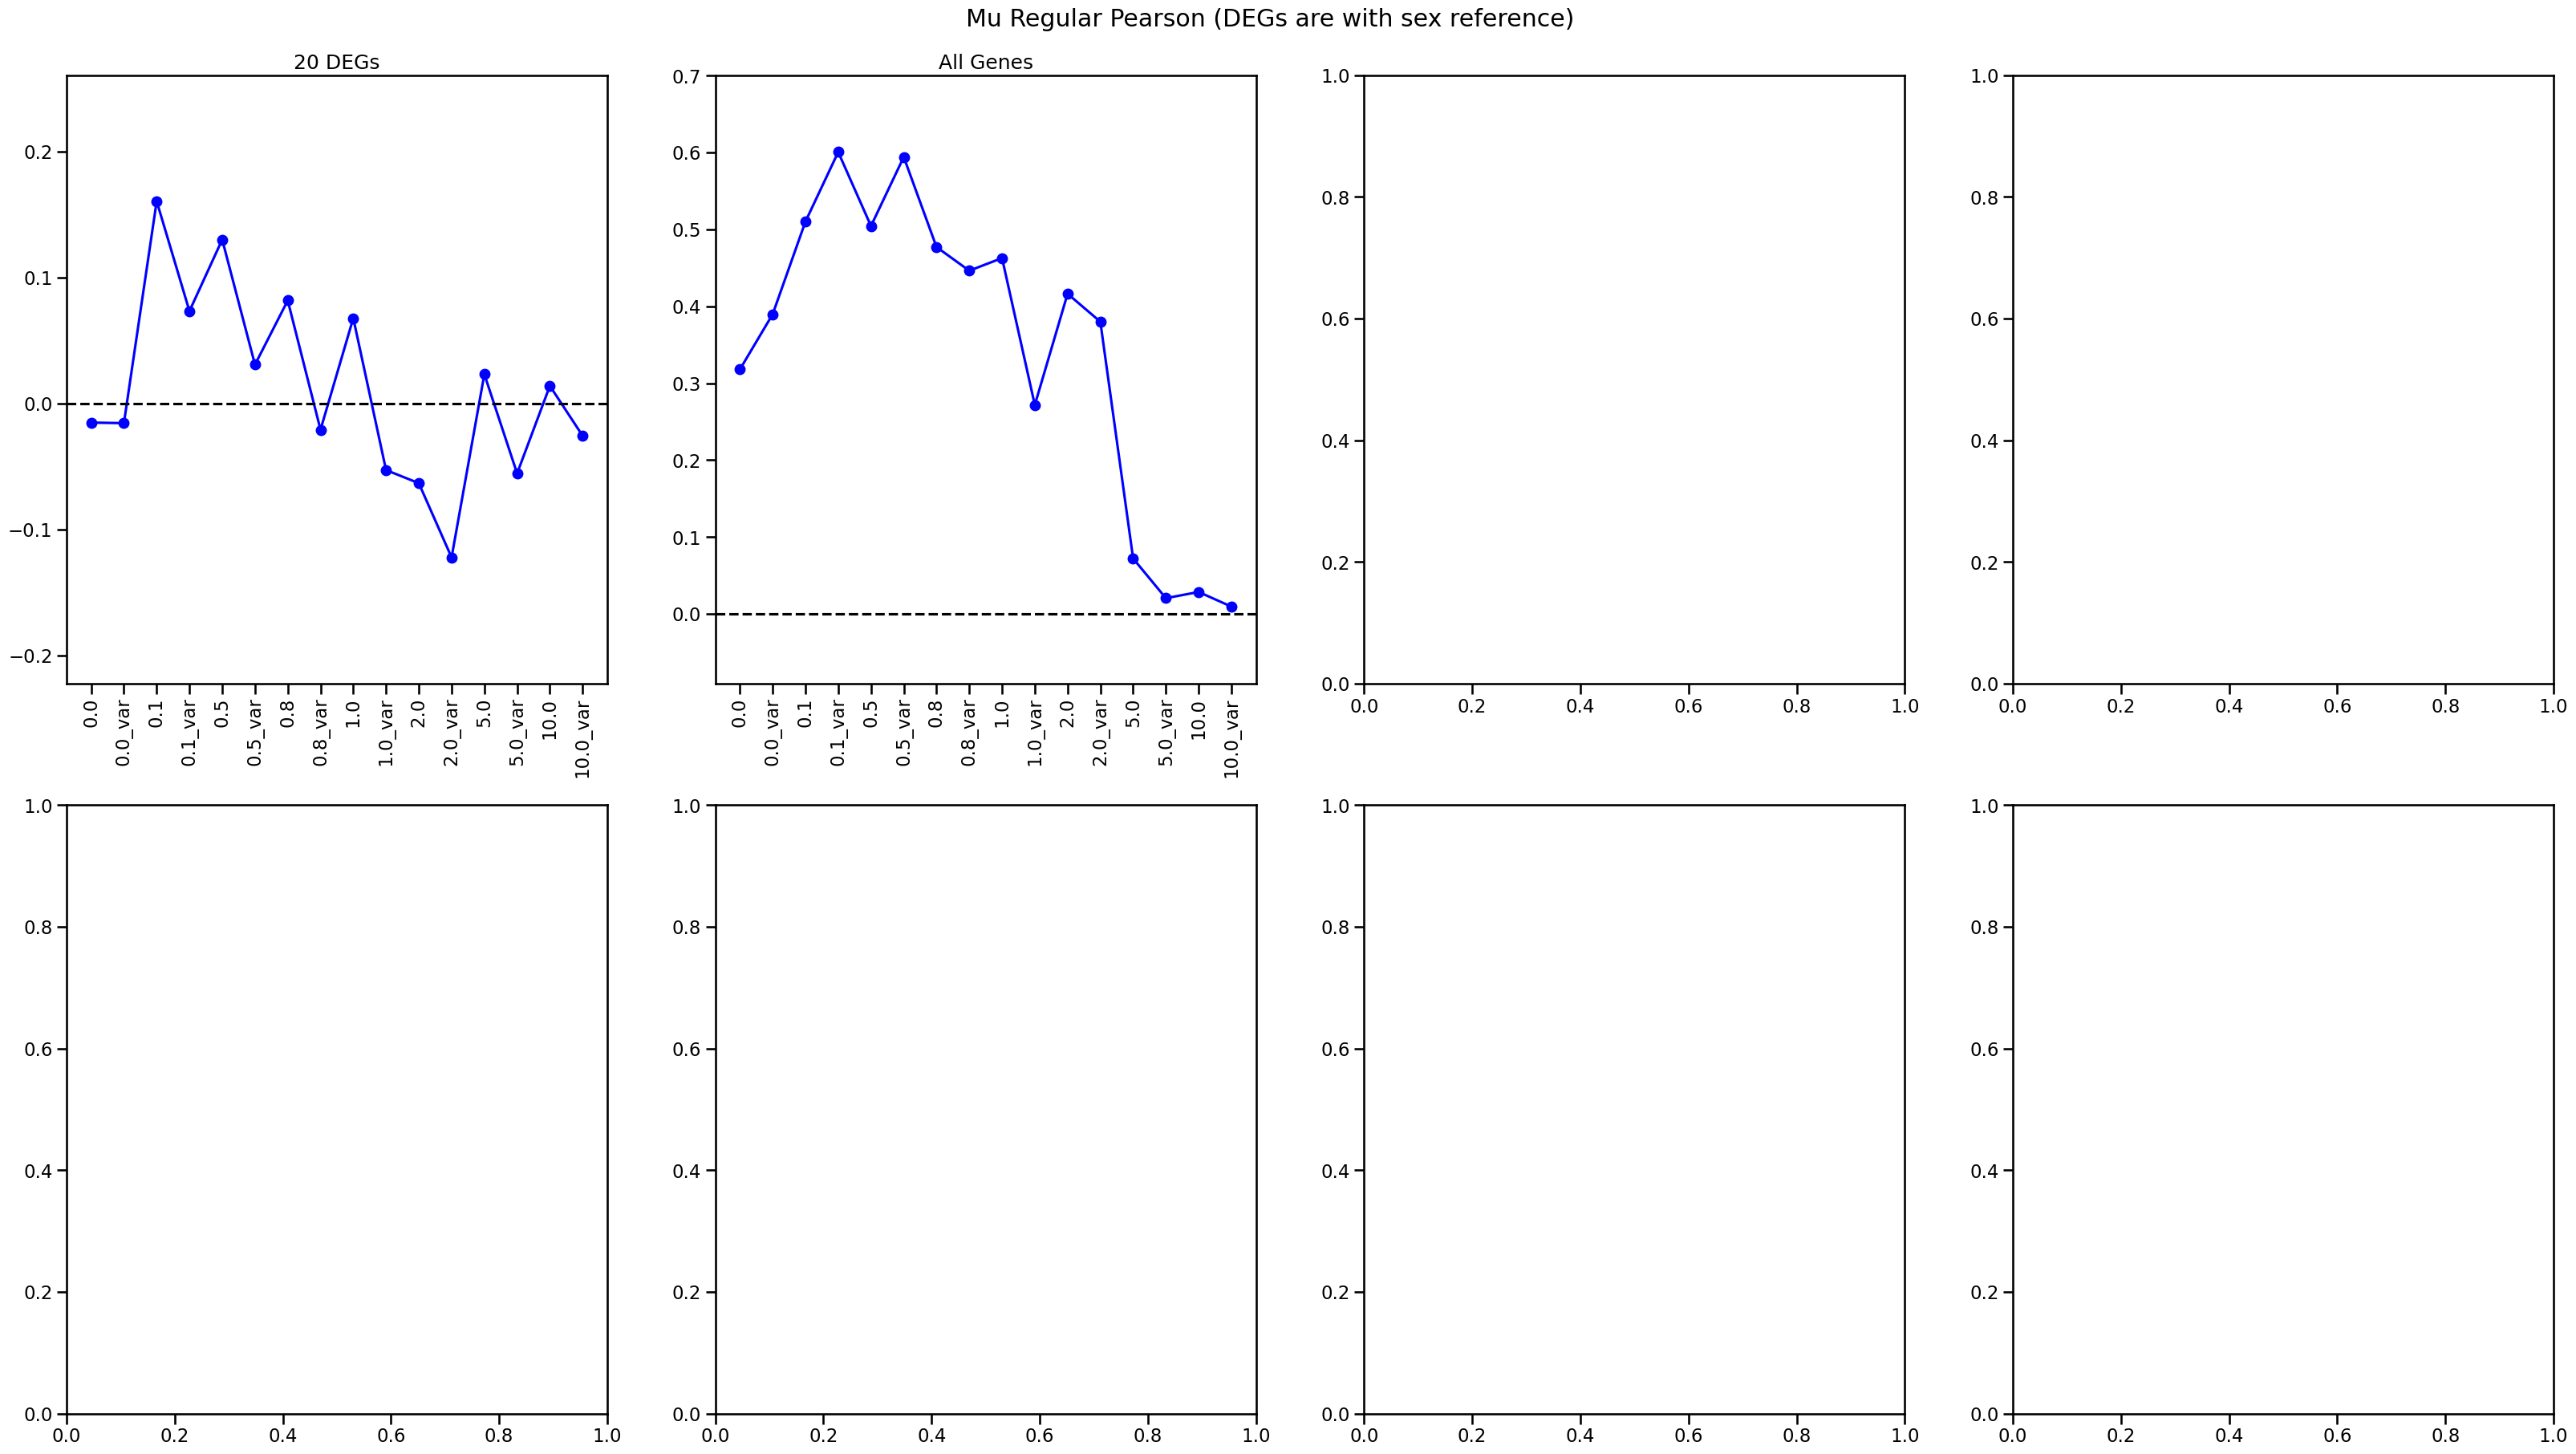

In [22]:
n_rows = r2_results.shape[0]
df = r2_results

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(40, 12))

for i in range(n_rows):
    row = df.iloc[i]
    ax = axes[i // 4, i % 4] 
    
    # Line plot instead of bar plot
    ax.plot(range(len(row)), row, marker='o', linestyle='-', color='blue')

    ax.axhline(y=0, color='black', linestyle='--')  # Baseline

    # Value labels above the points (adjust 'y' for vertical position)
    # for x, y in enumerate(row):
        # ax.text(x, y + 0.05, f'{y:.4f}', ha='center', va='bottom', fontsize=15)  

    ax.set_xticks(range(len(row)))
    ax.set_xticklabels(df.columns, rotation=90)
    ax.set_ylim(row.min() - 0.1, row.max() + 0.1)  

    if r2_results.index[i] == 'all':
        ax.set_title('All Genes')
    else:
        ax.set_title(f'{r2_results.index[i]} DEGs')

fig.suptitle('Mu Regular Pearson (DEGs are with sex reference)', y = 1.57)
plt.subplots_adjust(top=1.5)
plt.show()


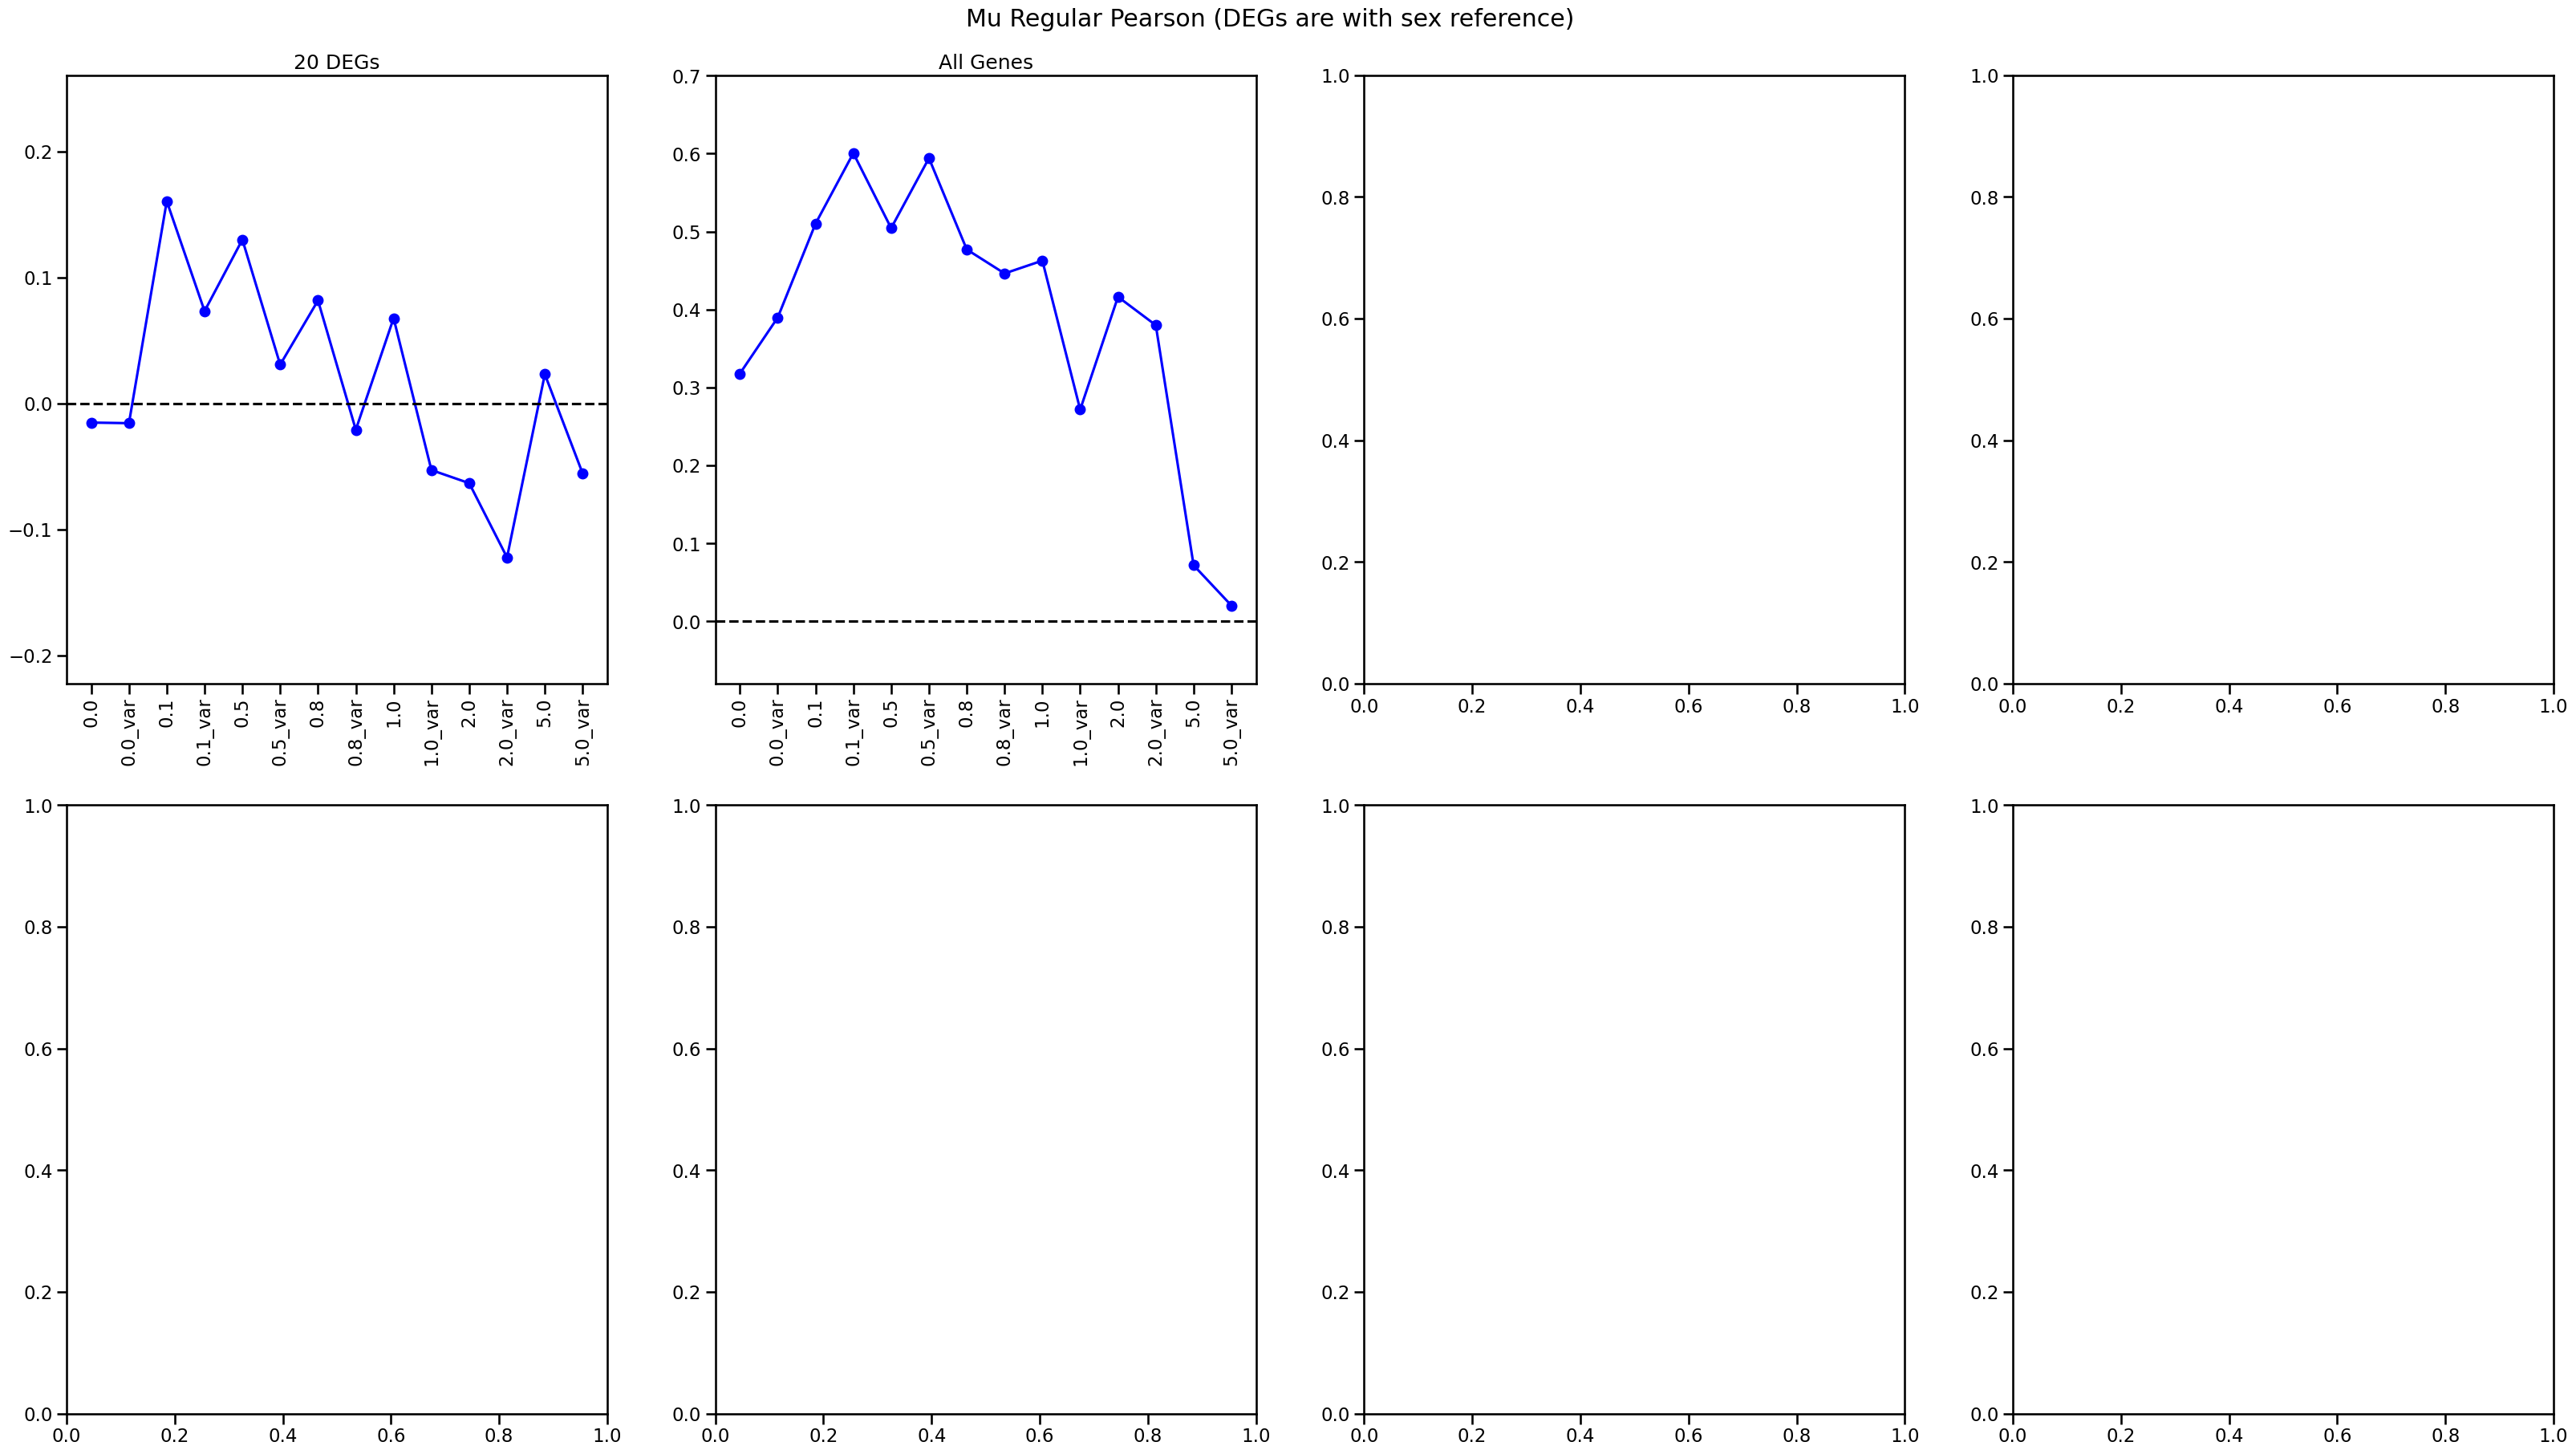

In [23]:
n_rows = r2_results.shape[0]
df = r2_results

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(40, 12))

for i in range(n_rows):
    row = df.iloc[i, :-2]
    ax = axes[i // 4, i % 4] 
    
    # Line plot instead of bar plot
    ax.plot(range(len(row)), row, marker='o', linestyle='-', color='blue')

    ax.axhline(y=0, color='black', linestyle='--')  # Baseline

    # Value labels above the points (adjust 'y' for vertical position)
    # for x, y in enumerate(row):
        # ax.text(x, y + 0.05, f'{y:.4f}', ha='center', va='bottom', fontsize=15)  

    ax.set_xticks(range(len(row)))
    ax.set_xticklabels(df.columns[:-2], rotation=90)
    ax.set_ylim(row.min() - 0.1, row.max() + 0.1)  

    if r2_results.index[i] == 'all':
        ax.set_title('All Genes')
    else:
        ax.set_title(f'{r2_results.index[i]} DEGs')

fig.suptitle('Mu Regular Pearson (DEGs are with sex reference)', y = 1.57)
plt.subplots_adjust(top=1.5)
plt.show()
